# Using OASIS for length of stay prediction

## Exercise:

We want to predict the length of stay (LOS) of the ICU patients based on the severity score OASIS of the fisrt 24  hours (and 48 hours) of an ICU stay on MIMIC-III.


Check also the following:
1. Compute:
    - the number of different patients in the dataset 
    - the number of different hospital admissions in the dataset 
    - the number of different icu stays in the dataset 
2. Show that we can have a patient with more than one icustay.
3. Revise the number of ICU admissions registered by the two different systems: Metavision and Carevue.
4. Compute the number of NaN OASIS values for your different implementations.

### OASIS

The Oxford Acute Severity of Illness Score (OASIS) consisted of age, elective surgery, prior length of stay (LOS) and seven physiologic measurements: Glasgow Coma Score (GCS), heart rate, mean arterial pressure (MAP), respiratory rate, temperature, urine output, ventilated.

For each variable, the worst score across the first day in ICU should be used to tabulate OASIS.

See [here](https://alistairewj.github.io/project/oasis/) for more information.

The concept elective surgery is where a patient is admitted to the intensive care unit either in routine preparation for a planned surgery or for stabilization after completion of a planned surgery. Elective surgery is an important covariate for many risk adjustments as patients who are admitted to the ICU for planned surgeries tend to be healthier than their counterparts.


### Instructions for the exercise:

- We provide you the variables already computed and saved in csv files, except age, elective surgery, pre-LOS and temperature.

- In order to compute the age and pre-LOS and consult the elective surgery information you need to merge tables PATIENTS, ADMISSIONS and ICUSTAYS. 
    - You should compute the age at the time the patient is admitted to the ICU from date of birth (dob) from PATIENTS table, then you can drop dob from the dataframe. 
    - For the pre-LOS you should compare intime from ICUSTAYS table and admittime from ADMISSIONS table. 
    - The elective surgery information is stored in the column admission_type of PATIENTS, ADMISSIONS and ICUSTAYS table.

- You need CHARTEVENTS table to get the temperature (measures in Fahrenheit and Celsius) and D_ITEMS table to consult the itemid for the measure.
    - The variables can be duplicated, since they can come from Carevue or Metavision source systems of MIMIC-III, so you have to look for the different labels.
    - You can use pandas.DataFrame.loc to look for the itemid corresponding to labels of the temperature in D_ITEMS table. If you do not know the exact label you are looking for, you can look for the strings in column label containing 'Temperature' using pandas.Series.str.contains as follows:
    > df_ditems.loc[df_ditems.label.str.contains('Temperature', case=False, na=False, regex=False)]


- Once you have computed these variables you can read the rest of variables provided in the csv files and merge them into a single dataframe to pass it to the OASIS function (see [here](https://gist.github.com/tompollard/d4c216d0c4ad30481c99)) to compute the severity score.


- The Glasgow Coma Scale is stored in a different way in Metavision and Carevue. 
    - Metavision saves the three tests separately: GCS - Eye Opening,  GCS - Motor Response, GCS - Verbal Response
    - Carevue saves a single test: GCS_total.
    - We provide you 4 separate csv files with these information: GCS_E_metavision.csv, GCS_M_metavision.csv, GCS_V_metavision.csv and  GCS_total_carevue.csv
    - You should concatenate the values and keep the worst one which corresponds to the minimum score.


- Each csv file contains a dataframe with: [subject_id, hadm_id, icustay_id, variable_Time and variable value], except for the ventilation which just contains:  [subject_id, hadm_id, icustay_id, variable_Time], since the important information is if there is ventilation or not (YES or NO) and when has been installed. 


- Normalize the measures time. Use intime, which provides the date and time the patient was transferred into the ICU, as the reference value to compute the time that has passed since then until the variable measurement were taken.

- After the normalization, you can filter the instances to keep the ones of the first 24 hours (or 48 hours) as observations to compute the OASIS score. 
    - Try to different strategies:
        - All the instances of the first 24 hours.
        - All the instances of the first 48 hours.

- For the prediction, consider the following binary label:
    - LOS < 4: short stay
    - Otherwise: long stay.
    
- Use Random forest to classify using a 5-fold cross validation.

- As can be seen in the code to compute OASIS, the score is NaN if any of the considered variables has all its instances as NaN. MIMIC-III has many NaN values and the demo subset is more limited in the number. So, the number of samples with OASIS different of NaNs considering first 24h is just 8. You can use the first 48h but the number is also very limited and the performance of the proposed classifier will be very poor. 

- We suggest that you also try an alternative to compute the OASIS score. 
    - You can change the original code to consider the variable as 0.0 (state in normal range) when all instances of the variable are NaN. For that use np.nansum instead of using sum in the line:
        > oasis_score = sum([oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp,oasis_temp, oasis_urine, oasis_vent, oasis_surg]). 
   
- Analyze the results of the three different alternatives (Original OASIS with 48h, Modification of OASIS with 24h and 48h):
    - Compare the mean accuracy
    - Build the confusion matrix



In [697]:
# Your solution here:

## Notes

Merging the first tables, Age, Pre-LOS and Elective Surgery (the following cells) are not automated and they have to be computed (executed) on by one. 

The rest of the variables are automated, with "period" as parameter (48 or 24). 

In [698]:
# General imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from operator import itemgetter
%matplotlib inline

Download the MIMIC-III Clinical Database Demo can be download from [here](https://physionet.org/content/mimiciii-demo/1.4/) and copy the csv files in a 'data' folder.


In [699]:
path = "data/" #path to my data folder 

1. Compute:
    - the number of different patients in the dataset 
    - the number of different hospital admissions in the dataset 
    - the number of different icu stays in the dataset 
2. Show that we can have a patient with more than one icustay.
3. Revise the number of ICU admissions registered by the two different systems: Metavision and Carevue.
4. Compute the number of NaN OASIS values for your different implementations.

In [700]:
print("1.\n")
patients=pd.read_csv(path+'PATIENTS.csv')
print("Unique patients:",patients.subject_id.nunique())
admissions=pd.read_csv(path+'ADMISSIONS.csv')
print('Unique admissions:', admissions.hadm_id.nunique())
icustays=pd.read_csv(path+'ICUSTAYS.csv')
print('Unique admissions at ICU:', icustays.icustay_id.nunique())

print("\n2.\n Number of unique rows of patient ID 10059 (for example):",len(icustays[icustays["subject_id"]==10059]))
print("\n3.\n",icustays.dbsource.value_counts())
print("\n4.\n")

1.

Unique patients: 100
Unique admissions: 129
Unique admissions at ICU: 136

2.
 Number of unique rows of patient ID 10059 (for example): 2

3.
 metavision    77
carevue       59
Name: dbsource, dtype: int64

4.



## Merging tables Patients, Admissions and ICUStays

In [701]:
#Remove some unwanted columns
icustays = icustays.drop(['row_id'],axis=1)
admissions = admissions.drop(['row_id'],axis=1)
# Merge
admissionsPatients=pd.merge(patients, admissions, on=['subject_id'],how="outer")
admissionsFinal=pd.merge(admissionsPatients, icustays, on=['subject_id', 'hadm_id'],how="outer")

# Instead of dropping lots of columns, get only the ones we are interested in.
admissionsFinal = admissionsFinal[['subject_id','dob','hadm_id','admittime','admission_type','icustay_id','intime','los']]

admissionsFinal.head()

,subject_id,dob,hadm_id,admittime,admission_type,icustay_id,intime,los
0,10006,2094-03-05 00:00:00,142345,2164-10-23 21:09:00,EMERGENCY,206504,2164-10-23 21:10:15,1.6325
1,10011,2090-06-05 00:00:00,105331,2126-08-14 22:32:00,EMERGENCY,232110,2126-08-14 22:34:00,13.8507
2,10013,2038-09-03 00:00:00,165520,2125-10-04 23:36:00,EMERGENCY,264446,2125-10-04 23:38:00,2.6499
3,10017,2075-09-21 00:00:00,199207,2149-05-26 17:19:00,EMERGENCY,204881,2149-05-29 18:52:29,2.1436
4,10019,2114-06-20 00:00:00,177759,2163-05-14 20:43:00,EMERGENCY,228977,2163-05-14 20:43:56,1.2938


## Age, Pre-LOS and Elective Surgery

1. You should compute the age at the time the patient is admitted to the ICU from date of birth (dob) from PATIENTS table, then you can drop dob from the dataframe. <br>
2. For the pre-LOS you should compare intime from ICUSTAYS table and admittime from ADMISSIONS table.<br>
3. The elective surgery information is stored in the column admission_type of PATIENTS, ADMISSIONS and ICUSTAYS table.<br>

In [702]:
# Age
intimeYear = pd.to_datetime(admissionsFinal['intime']).dt.year
dobYear = pd.to_datetime(admissionsFinal['dob']).dt.year
admissionsFinal["age"] = intimeYear-dobYear
#As stated here, DOB of patients >89 is shifted 300 years before their birth. Therefore, we cannot know their exact age.
#We hardcore this "300" ages to 90 in consequence, although the OASIS function works fine because filters ages > 89.
admissionsFinal.loc[admissionsFinal["age"]==300,"age"]=90
print("1.\n Age values:",admissionsFinal['age'])

# Pre-LOS
# Cast to datetime intime and admittime values
preLos = pd.to_datetime(admissionsFinal['intime'])-pd.to_datetime(admissionsFinal['admittime'])
# Convert it to hours and round to two decimals
admissionsFinal['prelos'] = np.round(preLos.dt.total_seconds()/3600, 2)
print("\n2.\n Pre-LOS values:", admissionsFinal['prelos'].values)

# Elective surgery information values
print("\n3.\n Elective Surgery values:",admissionsFinal["admission_type"].unique())

1.
 Age values: 0      70
1      36
2      87
3      74
4      49
       ..
131    55
132    90
133    45
134    73
135    58
Name: age, Length: 136, dtype: int64

2.
 Pre-LOS values: [ 2.0000e-02  3.0000e-02  3.0000e-02  7.3560e+01  2.0000e-02  2.0000e-02
  3.4000e+00  2.5650e+01  1.2577e+02  1.0460e+01  2.1570e+01  2.0000e-02
  4.2290e+01  1.0000e-02  5.0000e-02  2.0000e-02  9.6500e+00  2.2270e+01
  1.0000e-01  1.0000e-02  2.0000e-02  1.0000e-02  2.0000e-02  3.0000e-02
  2.7600e+00  2.0000e-02  1.0245e+02  2.0000e-02  5.4840e+01  2.0000e-02
  1.2080e+01  4.0000e-02  1.0000e-02  2.0000e-02  2.0000e-02  2.0000e-02
  1.0000e-02  1.0000e-02  2.0000e-02  3.0000e-02  2.4180e+02  6.1400e+00
  4.7100e+00  1.6488e+02  6.0000e-02  0.0000e+00  2.8800e+00  5.7170e+01
  2.6400e+00  1.6000e+00  3.0000e-02  6.7280e+01  3.0000e-02  1.7355e+02
  3.2990e+02  1.0180e+01  3.0000e-02  1.2467e+02  6.0000e-02  2.0000e-02
  3.0000e-02  2.0000e-02  1.1750e+02  2.0000e-02  9.9800e+00  1.4560e+01
  1.0000e-02 

## Temperature

I've defined the function $\texttt{toCelsiusT()}$ that gets a dataframe row, identifies the temperature unit and proceeds to convert it to Celsius if this unit is Fahrenheit. 

Then, we have the function $\texttt{first24_or_48()}$. We'll use it for all the following variables, because:

* 1. Gets the df with this variable info and computes the "hour" column which tells us the amount of hours elapsed between the date when the observation was made and the date when the patient went into the ICU.
* 2. Filters the df including only the rows of less than 24 or 48 hours.
* 3. For each unique icustay id, gets the minimum measure value

**In the case of temperature, it converts the ones in Fahrenheit to Celsius.**<br>
**In the case of Urine, instead of the minimum, the function returns the total urine output over 24 or 48 hours, as stated in the documentation**

In [703]:
def toCelsiusT(temperature):
    unit = temperature["valueuom"].values[0]
    val = temperature["valuenum"].values[0]
    if "F" in unit:
        return (5/9)*(val-32)
    return val

In [704]:
def first24_or_48(df,ICUsmall,period,timeName,varMin,urine=False,temperature=False):
    
    # Get "hadm_id","icustay_id","intime" variables from the icustay df
    df = pd.merge(df,ICUsmall,on=["subject_id","hadm_id","icustay_id"])
    
    #Compute the hours
    hours = pd.to_datetime(df[timeName]) - pd.to_datetime(df.intime)
    df["hours"] = np.round(hours.dt.total_seconds()/3600, 2)
    
    if temperature:
        #Fahrenheit to Celsius if needed
        df["temp_c"] = df.apply(lambda x: toCelsiusT(x.to_frame().T),axis=1)
    
    # Filter 24 or 48 hours periods
    df24 = df[(df["hours"]<=period) & (df["hours"]>0)]
    ids = df24["icustay_id"].unique()
    minDF = pd.DataFrame()
    for id in ids:
        temp = df24[df24['icustay_id']==id]
        
        #Urine is the sum, not the minimum
        if urine:
            minDF = minDF.append(pd.DataFrame({'subject_id':temp["subject_id"].unique(),"icustay_id":[id],"urine":[temp['urine'].sum()]}))
        else:
            # Get and locate the minimum
            min_ = temp[varMin].min()
            minDF = minDF.append(temp[temp[varMin]==min_][:1])
    return minDF[["subject_id","icustay_id",varMin]]

In [705]:
# Function that returns the dataframe of each temperature value for each icustay.
def get_temperature(period):
    ICUsmall = icustays[['subject_id',"hadm_id","icustay_id","intime"]]
    
    chartevents=pd.read_csv(path+'CHARTEVENTS.csv')
    items=pd.read_csv(path+'D_ITEMS.csv')
    
    #When looking at the "label" values of dfitems, the only labels we are interested in are the ones that start
    #with "Temperature C" or "Temperature F". I store get the itemid values of that rows
    itemsID = items[(items["label"].str.contains('^Temperature C', case=False, na=False, regex=True)) | 
         (items["label"].str.contains('^Temperature F', case=False, na=False, regex=True))][['itemid']].values

    #Remove the list of list
    itemsID = [i[0] for i in itemsID]

    #Get the rows of chartevents that contain those itemsID
    validTemps = chartevents[chartevents['itemid'].isin(itemsID)]
    validTemps = validTemps[validTemps['valuenum'].notna()][['subject_id', 'hadm_id', 'icustay_id', 'itemid', 'charttime',
                                                            'value', 'valuenum', 'valueuom']]
    
    return first24_or_48(validTemps,ICUsmall,period,"charttime","temp_c",temperature=True)
    

## Glasgow Coma Scale


In [706]:
# Function that returns the dataframe of each GCU value for each icustay.
def get_GCS(period):
    ICUsmall = icustays[['subject_id',"hadm_id","icustay_id","intime"]]
    
    #Reading
    GCS_E_metavision = pd.read_csv(path+"variables/GCS_E_metavision.csv",index_col=0)
    GCS_E_metavision.columns = ["subject_id","hadm_id","icustay_id","Time","GCS_V"]
    GCS_M_metavision = pd.read_csv(path+"variables/GCS_M_metavision.csv",index_col=0)
    GCS_M_metavision.columns = ["subject_id","hadm_id","icustay_id","Time","GCS_M"]
    GCS_V_metavision = pd.read_csv(path+"variables/GCS_V_metavision.csv",index_col=0)
    GCS_V_metavision.columns = ["subject_id","hadm_id","icustay_id","Time","GCS_E"]
    GCS_total_carevue = pd.read_csv(path+"variables/GCS_total_carevue.csv",index_col=0)
    
    # For Metavision, merge all the dataframes of GCS information
    GCSMeta = pd.merge(GCS_E_metavision,pd.merge(GCS_M_metavision,GCS_V_metavision,on=["subject_id","hadm_id","icustay_id","Time"]))
    
    #And now sum its values
    GCSMeta["GCS_total"] = GCSMeta["GCS_V"]+GCSMeta["GCS_M"]+GCSMeta["GCS_E"]
    GCSMeta = GCSMeta.drop(["GCS_V","GCS_M","GCS_E"],axis=1)

    # For Carevue just rename the columns
    CareMin = first24_or_48(GCS_total_carevue,ICUsmall,24,"GCS_total_Carevue_Time","GCS_total_Carevue")
    CareMin.columns = ["subject_id","icustay_id","GCS_total"]
    
    MetaMin = first24_or_48(GCSMeta,ICUsmall,period,"Time","GCS_total")
    
    return pd.concat([CareMin,MetaMin])

## HRate, Resp_rate, Urine, MAP

I decided to compute this 4 together

In [707]:
# Function that returns the dataframe of each variable value for each icustay.
def get_rest_variables(period):
    ICUsmall = icustays[['subject_id',"hadm_id","icustay_id","intime"]]
    
    #Reading
    hrate = pd.read_csv(path+"variables/heartRate.csv",index_col=0)
    respRate = pd.read_csv(path+"variables/RespiratoryRate.csv",index_col=0)
    urine = pd.read_csv(path+"variables/urine.csv",index_col=0)
    map_ = pd.read_csv(path+"variables/MAP.csv",index_col=0)
    
    heartRate = first24_or_48(hrate,ICUsmall,period,"hrate_Time","hrate")
    mapDF = first24_or_48(map_,ICUsmall,period,"MAP_Time","MAP")
    respirRate = first24_or_48(respRate,ICUsmall,period,"resp_rate_Time","resp_rate")
    ur = first24_or_48(urine,ICUsmall,period,"urine_Time","urine",True)
    
    return [heartRate,mapDF,respirRate,ur]
    

## Ventilation

Ventilation is done apart. First, we add a column named "ventilated" and input its values to "y". Then, we return the df.
Later on, we will merge this df to the "global" df and then replace the NaN values that we will find in this columns with "n".

In [708]:
def get_vent(period):
    ve = pd.read_csv(path+"variables/ventilation.csv",index_col=0)
    ve["ventilated"]="y"
    return ve.drop(["hadm_id","starttime"],axis=1)

## Oasis Score computing

Added the "allowNaN" parameter to do the sum respecting or not NaN values.

In [709]:
# The MIT License

# Copyright (c) 2015 Tom Pollard

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

def compute_oasis(pd_dataframe,allowNaN=False):
    """
    Takes Pandas DataFrame as an argument and computes Oxford Acute 
    Severity of Illness Score (OASIS) (http://oasisicu.com/)
    
    The DataFrame should include only measurements taken over the first 24h 
    from admission. pd_dataframe should contain the following columns:
    
    'prelos' => Pre-ICU length of stay, hours
    'age' => Age of patient, years
    'GCS_total' => Total Glasgow Coma Scale for patient
    'hrate' => All heart rate measurements
    'MAP' => All mean arterial blood pressure measurements
    'resp_rate' => All respiratory rate measurements
    'temp_c' => All temperature measurements, C
    'urine' => Total urine output over 24 h (note, not consecutive measurements)
    'ventilated' => Is patient ventilated? (y,n)
    'admission_type' => Type of admission (elective, urgent, emergency) 
    
    Reference:
    Johnson AE, Kramer AA, Clifford GD. A new severity of illness scale 
    using a subset of Acute Physiology And Chronic Health Evaluation 
    data elements shows comparable predictive accuracy.
    Crit Care Med. 2013 Jul;41(7):1711-8. doi: 10.1097/CCM.0b013e31828a24fe
    http://www.ncbi.nlm.nih.gov/pubmed/23660729
    """
    
    # 10 variables
    oasis_score, oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp, \
        oasis_temp, oasis_urine, oasis_vent, oasis_surg = 0,0,0,0,0,0,0,0,0,0,0   
    # Pre-ICU length of stay, hours
    for val in pd_dataframe['prelos']:
        if val >= 4.95 and val <= 24.0:
            oasis_prelos = np.nanmax([0,oasis_prelos])
        elif val > 311.8:
            oasis_prelos = np.nanmax([1,oasis_prelos])
        elif val > 24.0 and val <= 311.8:
            oasis_prelos = np.nanmax([2,oasis_prelos])
        elif val >= 0.17 and val < 4.95:
            oasis_prelos = np.nanmax([3,oasis_prelos])
        elif val < 0.17:
            oasis_prelos = np.nanmax([5,oasis_prelos])
        else:
            oasis_prelos = np.nanmax([np.nan,oasis_prelos])  
    if pd_dataframe['prelos'].isnull().all():
        oasis_prelos = np.nan 
    # Age, years
    for val in pd_dataframe['age']:
        if val < 24:
            oasis_age = np.nanmax([0,oasis_age])
        elif val >= 24 and val <= 53:
            oasis_age = np.nanmax([3,oasis_age])
        elif val > 53 and val <= 77:
            oasis_age = np.nanmax([6,oasis_age])
        elif val > 77 and val <= 89:
            oasis_age = np.nanmax([9,oasis_age])
        elif val > 89:
            oasis_age = np.nanmax([7,oasis_age])
        else:
            oasis_age = np.nanmax([np.nan,oasis_age])
    if pd_dataframe['age'].isnull().all():
        oasis_age = np.nan 
    # Glasgow Coma Scale
    for val in pd_dataframe['GCS_total']:
        if val == 15:
            oasis_gcs = np.nanmax([0,oasis_gcs])
        elif val == 14:
            oasis_gcs = np.nanmax([3,oasis_gcs])
        elif val >= 8 and val <= 13:
            oasis_gcs = np.nanmax([4,oasis_gcs])
        elif val >= 3 and val <= 7:
            oasis_gcs = np.nanmax([10,oasis_gcs])
        else:
            oasis_gcs = np.nanmax([np.nan,oasis_gcs])
    if pd_dataframe['GCS_total'].isnull().all():
        oasis_gcs = np.nan     
    # Heart rate
    for val in pd_dataframe['hrate']:
        if val >= 33 and val <= 88:
            oasis_hr = np.nanmax([0,oasis_hr])
        elif val > 88 and val <= 106:
            oasis_hr = np.nanmax([1,oasis_hr])
        elif val > 106 and val <= 125:
            oasis_hr = np.nanmax([3,oasis_hr])
        elif val < 33:
            oasis_hr = np.nanmax([4,oasis_hr])
        elif val > 125:
            oasis_hr = np.nanmax([6,oasis_hr])
        else:
            oasis_hr = np.nanmax([np.nan,oasis_hr])
    if pd_dataframe['hrate'].isnull().all():
        oasis_hr = np.nan 
    # Mean arterial pressure
    for val in pd_dataframe['MAP']:
        if val >=61.33 and val <= 143.44:
            oasis_map = np.nanmax([0,oasis_map])
        elif val >= 51.0 and val < 61.33:
            oasis_map = np.nanmax([2,oasis_map])
        elif (val >= 20.65 and val < 51.0) or (val > 143.44):
            oasis_map = np.nanmax([3,oasis_map])
        elif val < 20.65:
            oasis_map = np.nanmax([4,oasis_map])
        else:
            oasis_map = np.nanmax([np.nan,oasis_map])
    if pd_dataframe['MAP'].isnull().all():
        oasis_map = np.nan 
    # Respiratory Rate
    for val in pd_dataframe['resp_rate']:
        if val >=13 and val <= 22:
            oasis_resp = np.nanmax([0,oasis_resp])
        elif (val >= 6 and val <= 12) or (val >= 23 and val <= 30):
            oasis_resp = np.nanmax([1,oasis_resp])
        elif val > 30 and val <= 44:
            oasis_resp = np.nanmax([6,oasis_resp])
        elif val > 44:
            oasis_resp = np.nanmax([9,oasis_resp])
        elif val < 6:
            oasis_resp = np.nanmax([10,oasis_resp])
        else:
            oasis_resp = np.nanmax([np.nan,oasis_resp])
    if pd_dataframe['resp_rate'].isnull().all():
        oasis_resp = np.nan 
    # Temperature, C
    for val in pd_dataframe['temp_c']:
        if val >= 36.40 and val <= 36.88:
            oasis_temp = np.nanmax([0,oasis_temp])
        elif (val >= 35.94 and val < 36.40) or (val > 36.88 and val <= 39.88):
            oasis_temp = np.nanmax([2,oasis_temp])
        elif val < 33.22:
            oasis_temp = np.nanmax([3,oasis_temp])            
        elif val >= 33.22 and val < 35.94:
            oasis_temp = np.nanmax([4,oasis_temp])
        elif val > 39.88:
            oasis_temp = np.nanmax([6,oasis_temp])
        else:
            oasis_temp = np.nanmax([np.nan,oasis_temp])
    if pd_dataframe['temp_c'].isnull().all():
        oasis_temp = np.nan 
    # Urine output, cc/day (total over 24h)
    val = np.max(pd_dataframe['urine'])
    if val >=2544.0 and val <= 6896.0:
        oasis_urine = np.nanmax([0,oasis_urine])
    elif val >= 1427.0 and val < 2544.0:
        oasis_urine = np.nanmax([1,oasis_urine])
    elif val >= 671.0 and val < 1427.0:
        oasis_urine = np.nanmax([5,oasis_urine])
    elif val > 6896.0:
        oasis_urine = np.nanmax([8,oasis_urine])
    elif val < 671:
        oasis_urine = np.nanmax([10,oasis_urine])
    else:
        oasis_urine = np.nanmax([np.nan,oasis_urine])
    if pd_dataframe['urine'].isnull().all():
        oasis_urine = np.nan 
    # Ventilated y/n
    for val in pd_dataframe['ventilated']:
        if val == 'n':
            oasis_vent = np.nanmax([0,oasis_vent])
        elif val == 'y':
            oasis_vent = np.nanmax([9,oasis_vent])
        else:
            oasis_vent = np.nanmax([np.nan,oasis_vent])
    if pd_dataframe['ventilated'].isnull().all():
        oasis_vent = np.nan 
    # Elective surgery y/n
    for val in pd_dataframe['admission_type']:
        if val == 'elective':
            oasis_surg = np.nanmax([0,oasis_surg])
        elif val in ['urgent','emergency']:
            oasis_surg = np.nanmax([6,oasis_surg])
        else:
            oasis_surg = np.nanmax([np.nan,oasis_surg])
    if pd_dataframe['admission_type'].isnull().all():
        oasis_surg = np.nan 
    
    if allowNaN:
        return np.nansum([oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp, \
            oasis_temp, oasis_urine, oasis_vent, oasis_surg])
    else:
        # Return sum
        oasis_score = sum([oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp, \
            oasis_temp, oasis_urine, oasis_vent, oasis_surg])
    
    return oasis_score

This function gets a dataframe and adds the column "oasis" that is the OASIS score computed with the function above. With the parameter "allowNaN" we allow or not NaN's in the final sum.

In [710]:
def addOasis(data,allowNaN):
    df = data.copy()
    df["oasis"]= data.apply(lambda x: compute_oasis(x.to_frame().T,allowNaN),axis=1)
    return df

## Training and predicting

In [721]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

This function creates the "global" dataframe with all the needed variables. 

In [712]:
def getData(starterDF,period,allowNaN):
    # Temperature
    starterDF = pd.merge(starterDF,get_temperature(period),on=["subject_id","icustay_id"],how="outer")
    
    # GCS
    starterDF = pd.merge(starterDF,get_GCS(period),on=["subject_id","icustay_id"],how="outer")
    
    # HRate, Resp_rate, Urine, MAP
    for df in get_rest_variables(period):
        starterDF = pd.merge(starterDF,df,on=["subject_id","icustay_id"],how="outer")
    
    # Ventilation
    vent = get_vent(period)
    starterDF = pd.merge(starterDF,vent,on=["subject_id","icustay_id"],how="outer")
    starterDF['ventilated'] = starterDF['ventilated'].replace(np.nan, "n")
    starterDF = starterDF.drop_duplicates()
    
    # OASIS Scores
    starterDF = addOasis(starterDF,allowNaN)[['oasis','los']]
    
    # LOS to target variable for training.
    starterDF['los'] = np.where(starterDF['los']<4, 0, 1)
    
    return starterDF

In [713]:
#Get the 3 dataframes:
# data24: data from the last 24 hours, allowing the OASIS final sum with NaN values in it.
# dataNaN48: data from the last 24 hours, NOT ALLOWING the OASIS final sum with NaN values in it.
# data48: data from the last 48 hours, allowing the OASIS final sum with NaN values in it.

#Takes ~30 seconds to execute.

data24 = getData(admissionsFinal,24,True)
dataNaN48 = getData(admissionsFinal,48,False)
data48 = getData(admissionsFinal,48,True)

C:\Users\blair\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: DtypeWarning: Columns (8,10,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [714]:
#Shapes
print(data24.shape,dataNaN48.shape,data48.shape)

(136, 2) (136, 2) (136, 2)


In [715]:
print("NaN's in data24 (from last 24 hours):",data24["oasis"].isna().sum(),
     "\nNaN's in dataNaN48 (from last 48 hours):",dataNaN48["oasis"].isna().sum(),
     "\nNaN's in data48 (from last 48 hours):",data48["oasis"].isna().sum())

NaN's in data24 (from last 24 hours): 0 
NaN's in dataNaN48 (from last 48 hours): 83 
NaN's in data48 (from last 48 hours): 0


This following function does the traing and prediction of the LOS. <br>
First, builds the train and test vectors (X and y) replacing or not NaN values.<br>
Then, builds a Stratified K-Folds cross-validator that provides me the train/test indices for the later prediction with RandomForest. <br>
So, for each index we compute the final prediction and store this value into yhat. Finally, we print the final accuracy and confusion matrix.

In [717]:
def train(data):
    
    cv = StratifiedKFold(random_state=0,n_splits=5,shuffle=True)
    
    X = data.dropna().iloc[:,0].values.reshape(-1,1)
    y = data.dropna().iloc[:,1].values
    print("X shape:",X.shape,"y shape",y.shape)
    yhat = np.zeros((X.shape[0])).reshape(-1,1)
    
    for train_idx, test_idx in cv.split(X,y):
        X_train,y_train = X[train_idx,:],y[train_idx]
        X_test,y_test = X[test_idx,:],y[test_idx]

        clf = RandomForestClassifier(random_state=0)
        clf.fit(X_train,y_train)
        yhat[test_idx] = clf.predict(X_test).reshape(-1,1)
    
    #For the mean or std if we want
    scores = cross_val_score(clf,X,y,cv=5)
    
    print("Accuracy of the model:",np.round(metrics.accuracy_score(y,yhat),2),
          "\nMean Accuracy:",np.round(scores.mean(),2),
          "\nF1 Score:",np.round(metrics.f1_score(y,yhat),2),
         "\nConfusion Matrix:\n",metrics.confusion_matrix(y,yhat),
         "\n",plot_confusion_matrix(clf, X_test, y_test))
        

## Results

X shape: (136, 1) y shape (136,)
Accuracy of the model: 0.66 
Mean Accuracy: 0.68 
F1 Score: 0.28 
Confusion Matrix:
 [[81 19]
 [27  9]] 


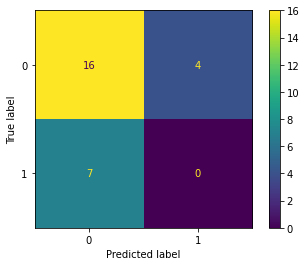

In [722]:
train(data24)

X shape: (136, 1) y shape (136,)
Accuracy of the model: 0.68 
Mean Accuracy: 0.75 
F1 Score: 0.27 
Confusion Matrix:
 [[84 16]
 [28  8]] 


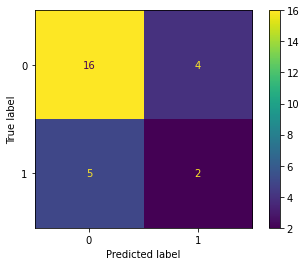

In [723]:
train(data48)

X shape: (53, 1) y shape (53,)
Accuracy of the model: 0.53 
Mean Accuracy: 0.49 
F1 Score: 0.39 
Confusion Matrix:
 [[20 10]
 [15  8]] 


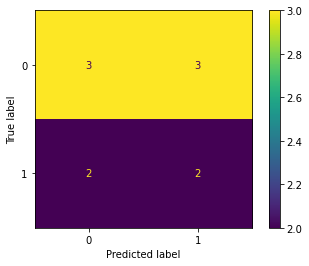

In [724]:
train(dataNaN48)

## Conclusions

* My best model is the one build with data from the last 48 hours, allowing the OASIS final sum with NaN values in it. 
* My worst model is the one build with data from the last 48 hours but not allowing the OASIS final sum with NaN values in it.
* The dataset with data from the last 24 hours also gave me a good accuracy score.


| Dataset              | Accuracy (%) |
|----------------------|--------------|
| 48 hours             |           68 |
| 24 hours             |           66 |
| 48 hours, NaN values |           53 |

That is reasonable because the 48 hours with NaN values only has 53 rows, while the others have all of them.

* The 24 hour dataset has LESS False positives than the 48-hour dataset. It also has less True Positives though. 
* So, in conclusion, although they are pretty similar, I would choose the 48-hour dataset allowing NaN values because it has the best Accuracy and the barely the same F1 Score.